In [11]:
import torch
import torch.nn
import torchvision.transforms as transforms
import torchvision.datasets
from torch.autograd import Variable
from torch.nn import Parameter
import torch.nn as nn
from torch import Tensor
import torch.nn.functional as F
from torch.utils.data import DataLoader
import math

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

cuda = True if torch.cuda.is_available() else False
Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

torch.manual_seed(125)

if torch.cuda.is_available() :
    torch.cuda.manual_seed_all(125)

In [4]:
mnist_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, ), (1.0, ))
])

In [7]:
from torchvision.datasets import MNIST
download_root = '../080289-main/chap07/MNIST_DATASET'

train_dataset = MNIST(download_root, transform=mnist_transform, train=True,
                    download=True)
valid_dataset = MNIST(download_root, transform=mnist_transform, train=False,
                     download=True)
test_dataset = MNIST(download_root, transform=mnist_transform, train=False,
                    download=True)

In [8]:
batch_size=64
train_loader = DataLoader(dataset=train_dataset,
                         batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(dataset=test_dataset,
                         batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset,
                        batch_size=batch_size, shuffle=True)

In [9]:
batch_size=100
n_iters=6000
num_epochs = n_iters/(len(train_dataset)/batch_size)
num_epochs = int(num_epochs)

In [15]:
class GRUCell(nn.Module) :
    def __init__(self, input_size, hidden_size, bias=True) :
        super(GRUCell, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.bias = bias
        self.x2h = nn.Linear(input_size, 3 * hidden_size, bias=bias)
        self.h2h = nn.Linear(hidden_size, 3*hidden_size, bias=bias)
        self.reset_parameters()
        
    def reset_parameters(self) :
        std = 1.0 / math.sqrt(self.hidden_size)
        for w in self.parameters() : 
            w.data.uniform_(-std, std)
            
    def forward(self, x, hidden) : 
        x = x.view(-1, x.size(1))
        
        gate_x = self.x2h(x)
        gate_h = self.h2h(hidden)
        
        gate_x = gate_x.squeeze()
        gate_h = gate_h.squeeze()
        
        i_r, i_i, i_n = gate_x.chunk(3, 1)
        h_r, h_i, h_n = gate_h.chunk(3, 1)
        
        resetgate = F.sigmoid(i_r + h_r)
        inputgate = F.sigmoid(i_i + h_i)
        newgate = F.tanh(i_n + (resetgate * h_n))
        
        hy = newgate + inputgate * (hidden - newgate)
        return hy

In [19]:
class GRUModel(nn.Module) :
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim, bias=True) :
        super(GRUModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        self.gru_cell = GRUCell(input_dim, hidden_dim, layer_dim)
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x) :
        if torch.cuda.is_available() :
            h0 = Variable(torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).cuda())
        else :
            h0 = Variable(torch.zeros(self.layer_dim, x.size(0), self.hidden_dim))
            
        outs = []
        hn = h0[0, :, :]
        
        for seq in range(x.size(1)) : 
            hn = self.gru_cell(x[:, seq, :], hn)
            outs.append(hn)
        out = outs[-1].squeeze()
        out = self.fc(out)
        return out

In [20]:
# 옵티마이저, 손실 함수
input_dim = 28
hidden_dim = 128
layer_dim = 1
output_dim = 10

model = GRUModel(input_dim, hidden_dim, layer_dim, output_dim)

if torch.cuda.is_available() :
    model.cuda()
    
criterion = nn.CrossEntropyLoss()
learning_rate = 0.1

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [21]:
# 학습 및 검증
seq_dim = 28
loss_list = []
iter = 0
for epoch in range(num_epochs) :
    for i, (images, labels) in enumerate(train_loader) :
        if torch.cuda.is_available() :
            images = Variable(images.view(-1, seq_dim, input_dim).cuda())
            labels = Variable(labels.cuda())
            
        else :
            images = Variable(images.view(-1, seq_dim, input_dim))
            labels = Variable(labels)
            
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        if torch.cuda.is_available() : 
            loss.cuda()
            
        loss.backward()
        optimizer.step()
        
        loss_list.append(loss.item())
        iter += 1
        
        if iter % 500 == 0 :
            correct = 0
            total = 0
            for images, labels in valid_loader : 
                if torch.cuda.is_available() :
                    images = Variable(images.view(-1, seq_dim, input_dim).cuda())
                else :
                    images = Variable(images.view(-1, seq_dim, input_dim))
                    
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                
                if torch.cuda.is_available() :
                    correct += (predicted.cpu() == labels.cpu()).sum()
                else :
                    correct += (predicted == labels).sum()
                    
            accuracy = 100 * correct / total
            print(f'Iteration : {iter}. Loss : {loss.item()}. Accuracy : {accuracy}')

Iteration : 500. Loss : 1.367768406867981. Accuracy : 54.65999984741211
Iteration : 1000. Loss : 0.6918953061103821. Accuracy : 79.66999816894531
Iteration : 1500. Loss : 0.28622865676879883. Accuracy : 89.91999816894531
Iteration : 2000. Loss : 0.32157325744628906. Accuracy : 91.16999816894531
Iteration : 2500. Loss : 0.18764743208885193. Accuracy : 93.5199966430664
Iteration : 3000. Loss : 0.07681035995483398. Accuracy : 95.44000244140625
Iteration : 3500. Loss : 0.08541690558195114. Accuracy : 96.36000061035156
Iteration : 4000. Loss : 0.059621769934892654. Accuracy : 96.69999694824219
Iteration : 4500. Loss : 0.11129660904407501. Accuracy : 96.81999969482422
Iteration : 5000. Loss : 0.1259971410036087. Accuracy : 96.80999755859375
Iteration : 5500. Loss : 0.04892083257436752. Accuracy : 97.48999786376953
Iteration : 6000. Loss : 0.040439173579216. Accuracy : 97.73999786376953
Iteration : 6500. Loss : 0.035291239619255066. Accuracy : 97.80999755859375
Iteration : 7000. Loss : 0.0080

In [22]:
def evaluate(model, val_iter) : 
    corrects, total, total_loss = 0, 0, 0
    model.eval()
    for images, labels in val_iter :
        if torch.cuda.is_available() :
            images = Variable(images.view(-1, seq_dim, input_dim).cuda())
        else :
            images = Variable(images.view(-1, seq_dim, input_dim)).to(device)
            
        logit = model(images).to(device)
        loss = F.cross_entropy(logit, labels, reduction='sum')
        _, predicted = torch.max(logit.data, 1)
        total += labels.size(0)
        total_loss += loss.item()
        corrects += (predicted == labels).sum()
        
    avg_loss = total_loss / len(val_iter.dataset)
    avg_accuracy = corrects / total
    return avg_loss, avg_accuracy

In [23]:
test_loss, test_acc = evaluate(model, test_loader)
print(f'Test Loss : {test_loss:5.2f} | Test Accuracy : {test_acc:5.2f}')

Test Loss :  0.07| Test Accuracy :  0.98


## GRU 계층 구현

In [29]:
import os
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from torch.autograd import Variable
from tqdm import tqdm_notebook
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

In [30]:
device =torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
data = pd.read_csv('../080289-main/chap07/data/SBUX.csv')
print(data.dtypes)

Date          object
Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object


In [31]:
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)
data['Volume'] = data['Volume'].astype(float)

In [32]:
X = data.iloc[:, :-1]
y = data.iloc[:, 5:6]
print(X)
print(y)

                  Open        High         Low       Close   Adj Close
Date                                                                  
2019-12-11   86.260002   86.870003   85.849998   86.589996   84.145752
2019-12-12   88.000000   88.889999   87.540001   88.209999   85.720032
2019-12-13   88.019997   88.790001   87.580002   88.669998   86.167046
2019-12-16   89.139999   89.300003   88.430000   88.779999   86.273941
2019-12-17   88.870003   88.970001   87.470001   88.129997   85.642288
...                ...         ...         ...         ...         ...
2020-12-04  101.349998  102.940002  101.070000  102.279999  101.442787
2020-12-07  102.010002  102.220001  100.690002  101.410004  100.579918
2020-12-08  100.370003  101.570000  100.010002  101.209999  100.381554
2020-12-09  101.940002  102.209999  100.099998  100.400002   99.578186
2020-12-10  103.510002  106.089996  102.750000  105.389999  104.527336

[253 rows x 5 columns]
                Volume
Date                  
2019-12

In [33]:
ms = MinMaxScaler()
ss = StandardScaler()

X_ss = ss.fit_transform(X)
y_ms = ms.fit_transform(y)

X_train = X_ss[:200, :]
X_test = X_ss[200:, :]

y_train = y_ms[:200, :]
y_test = y_ms[200:, :]

print('Training Shape :', X_train.shape, y_train.shape)
print('Testing Shape :', X_test.shape, y_test.shape)

Training Shape : (200, 5) (200, 1)
Testing Shape : (53, 5) (53, 1)


In [35]:
X_train_tensors = Variable(torch.Tensor(X_train))
X_test_tensors = Variable(torch.Tensor(X_test))

y_train_tensors = Variable(torch.Tensor(y_train))
y_test_tensors = Variable(torch.Tensor(y_test))

X_train_tensors_f = torch.reshape(X_train_tensors, 
                                  (X_train_tensors.shape[0], 1, X_train_tensors.shape[1]))

X_test_tensors_f = torch.reshape(X_test_tensors,
                                (X_test_tensors.shape[0], 1, X_test_tensors.shape[1]))

print('Training Shape :', X_train.shape, y_train.shape)
print('Testing Shape :', X_test.shape, y_test.shape)

Training Shape : (200, 5) (200, 1)
Testing Shape : (53, 5) (53, 1)


In [38]:
class GRU(nn.Module) :
    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length) :
        super(GRU, self).__init__()
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length
        
        self.gru = nn.GRU(input_size=input_size,hidden_size=hidden_size,
                         num_layers=num_layers,batch_first=True)
        self.fc_1 = nn.Linear(hidden_size, 128)
        self.fc = nn.Linear(128, num_classes)
        self.relu = nn.ReLU()
        
    def forward(self, x) :
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))
        output, (hn) = self.gru(x, (h_0))
        hn = hn.view(-1, self.hidden_size)
        out = self.relu(hn)
        out = self.fc_1(out)
        out = self.relu(out)
        out = self.fc(out)
        return out

In [42]:
num_epochs = 1000
learning_rate = 0.0001

input_size=5
hidden_size=2
num_layers=1

num_classes=1
model=GRU(num_classes,input_size,hidden_size,num_layers,X_train_tensors_f.shape[1])

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [43]:
for epoch in range(num_epochs) :
    outputs = model.forward(X_train_tensors_f)
    optimizer.zero_grad()
    loss = criterion(outputs, y_train_tensors)
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0 :
        print(f'Epoch : {epoch}, loss : {loss.item():1.5f}')

Epoch : 0, loss : 0.25149
Epoch : 100, loss : 0.08289
Epoch : 200, loss : 0.04005
Epoch : 300, loss : 0.03468
Epoch : 400, loss : 0.03412
Epoch : 500, loss : 0.03383
Epoch : 600, loss : 0.03354
Epoch : 700, loss : 0.03326
Epoch : 800, loss : 0.03295
Epoch : 900, loss : 0.03263


In [45]:
df_x_ss = ss.transform(data.iloc[:, :-1])
df_y_ms = ms.transform(data.iloc[:, -1:])

df_x_ss = Variable(torch.Tensor(df_x_ss))
df_y_ms = Variable(torch.Tensor(df_y_ms))
df_x_ss = torch.reshape(df_x_ss, (df_x_ss.shape[0], 1, df_x_ss.shape[1]))

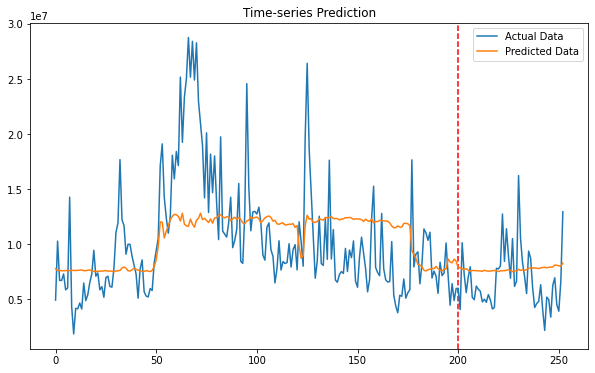

In [46]:
train_predict = model(df_x_ss)
predicted = train_predict.data.numpy()

label_y = df_y_ms.data.numpy()

predicted = ms.inverse_transform(predicted)
label_y = ms.inverse_transform(label_y)
plt.figure(figsize=(10, 6))
plt.axvline(x=200, c='r', linestyle='--')

plt.plot(label_y, label='Actual Data')
plt.plot(predicted, label='Predicted Data')
plt.title('Time-series Prediction')
plt.legend()
plt.show()